## **Task 1. Get Language Pair**

In [32]:
pip install -q pythainlp sacremoses sentencepiece tqdm matplotlib seaborn

In [55]:
import torch.nn as nn
import random
import math
from tqdm import tqdm

In [33]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/data"

MAX_SAMPLES = 20000
VOCAB_SIZE  = 8000
MAX_LEN     = 60
BATCH_SIZE  = 64
EMB_DIM     = 128
HID_DIM     = 256
DROPOUT     = 0.3
N_EPOCHS    = 5
SEED        = 42

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import os, random, unicodedata

RAW_DIR = os.path.join(BASE_DIR, "raw")
PROC_DIR = os.path.join(BASE_DIR, "processed")
os.makedirs(PROC_DIR, exist_ok=True)

EN_PATH = os.path.join(RAW_DIR, "OpenSubtitles.en-th.en")
TH_PATH = os.path.join(RAW_DIR, "OpenSubtitles.en-th.th")

In [37]:
def load_parallel(en_path, th_path, max_samples=None):
    pairs = []
    with open(en_path, encoding="utf-8") as f_en, open(th_path, encoding="utf-8") as f_th:
        for i, (en, th) in enumerate(zip(f_en, f_th)):
            en = en.strip()
            th = th.strip()
            if en and th:
                pairs.append((th, en))  # (src=Thai, tgt=English)
            if max_samples and i >= max_samples:
                break
    return pairs

In [38]:
pairs = load_parallel("/content/drive/MyDrive/Colab Notebooks/data/raw/OpenSubtitles.en-th.en"
,"/content/drive/MyDrive/Colab Notebooks/data/raw/OpenSubtitles.en-th.th",max_samples=300000)
print(pairs[0])

('เกิดอะไรขึ้น - มีอะไร', 'What happened?')


- **Clean & Filter**

In [39]:
import unicodedata

def normalize(s):
    s = unicodedata.normalize("NFC", s)
    s = s.strip()
    s = " ".join(s.split())
    return s

def filter_pair(th, en, max_len=60):
    return len(th) > 0 and len(en) > 0

In [40]:
clean_pairs = []
for th, en in pairs:
    th_n = normalize(th)
    en_n = normalize(en)
    if filter_pair(th_n, en_n):
        clean_pairs.append((th_n, en_n))

- **Split data & Save data**

In [41]:
import random
random.shuffle(clean_pairs)

N = len(clean_pairs)
train = clean_pairs[:int(0.8*N)]
valid = clean_pairs[int(0.8*N):int(0.9*N)]
test  = clean_pairs[int(0.9*N):]

In [42]:
def save_tsv(pairs, path):
    with open(path, "w", encoding="utf-8") as f:
        for th, en in pairs:
            f.write(th + "\t" + en + "\n")

In [43]:
save_tsv(train, "/content/drive/MyDrive/Colab Notebooks/data/processed/train.tsv")
save_tsv(valid, "/content/drive/MyDrive/Colab Notebooks/data/processed/valid.tsv")
save_tsv(test,  "/content/drive/MyDrive/Colab Notebooks/data/processed/test.tsv")

- **Tokenization**

In [44]:
from pythainlp.tokenize import word_tokenize

def tokenize_th(s):
    return word_tokenize(s, engine="newmm")

def tokenize_en(s):
    return s.lower().split()

In [45]:
print(tokenize_th("ฉันรักประเทศไทย"))
print(tokenize_en("I love Thailand"))

['ฉัน', 'รัก', 'ประเทศ', 'ไทย']
['i', 'love', 'thailand']


In [47]:
from collections import Counter
import torch
from torch.utils.data import DataLoader
from pythainlp.tokenize import word_tokenize

SPECIALS = ["<pad>", "<sos>", "<eos>", "<unk>"]
PAD, SOS, EOS, UNK = SPECIALS

def tokenize_th(s): return word_tokenize(s, engine="newmm")
def tokenize_en(s): return s.lower().split()

def load_tsv(path):
    pairs = []
    with open(path, encoding="utf-8") as f:
        for line in f:
            th, en = line.rstrip("\n").split("\t")
            pairs.append((th, en))
    return pairs

train_pairs = load_tsv("/content/drive/MyDrive/Colab Notebooks/data/processed/train.tsv")
valid_pairs = load_tsv("/content/drive/MyDrive/Colab Notebooks/data/processed/valid.tsv")
test_pairs  = load_tsv("/content/drive/MyDrive/Colab Notebooks/data/processed/test.tsv")

def build_vocab(pairs, tokenizer, min_freq=2, max_size=VOCAB_SIZE):
    counter = Counter()
    for th, en in pairs:
        text = th if tokenizer == tokenize_th else en
        counter.update(tokenizer(text))

    itos = SPECIALS[:]  # index -> token
    for tok, freq in counter.most_common():
        if freq < min_freq:
            break
        if tok not in itos:
            itos.append(tok)
        if len(itos) >= max_size:
            break

    stoi = {tok: i for i, tok in enumerate(itos)}  # token -> index
    return stoi, itos

src_stoi, src_itos = build_vocab(train_pairs, tokenize_th)
tgt_stoi, tgt_itos = build_vocab(train_pairs, tokenize_en)

PAD_IDX = src_stoi[PAD]
TGT_PAD_IDX = tgt_stoi[PAD]

print("SRC_VOCAB_SIZE:", len(src_itos))
print("TGT_VOCAB_SIZE:", len(tgt_itos))

PAD_IDX = src_stoi[PAD]
TGT_PAD_IDX = tgt_stoi[PAD]

def numericalize(tokens, stoi):
    return [stoi.get(t, stoi[UNK]) for t in tokens]

def encode_src(th):
    tokens = [SOS] + tokenize_th(th) + [EOS]
    return numericalize(tokens, src_stoi)

def encode_tgt(en):
    tokens = [SOS] + tokenize_en(en) + [EOS]
    return numericalize(tokens, tgt_stoi)

def collate_fn(batch):
    src_list, tgt_list = [], []
    for th, en in batch:
        src_list.append(torch.tensor(encode_src(th), dtype=torch.long))
        tgt_list.append(torch.tensor(encode_tgt(en), dtype=torch.long))

    src = torch.nn.utils.rnn.pad_sequence(src_list, padding_value=PAD_IDX)       # [src_len, batch]
    tgt = torch.nn.utils.rnn.pad_sequence(tgt_list, padding_value=TGT_PAD_IDX)  # [tgt_len, batch]
    return src, tgt

train_loader = DataLoader(train_pairs, batch_size=64, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_pairs, batch_size=64, shuffle=False, collate_fn=collate_fn)

src, tgt = next(iter(train_loader))
print(src.shape, tgt.shape)


SRC_VOCAB_SIZE: 8000
TGT_VOCAB_SIZE: 8000
torch.Size([23, 64]) torch.Size([17, 64])


## **Task 2 - Experiment with Attention Mechanisms**

- **Encoder**

In [49]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=PAD_IDX)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))        # [src_len, batch, emb]
        outputs, hidden = self.rnn(embedded)                # outputs: [src_len, batch, hid*2]
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2], hidden[-1]), dim=1)))  # [batch, hid]
        return outputs, hidden

- **Attention**

In [50]:
# Dot
class GeneralAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim

    def forward(self, decoder_hidden, encoder_outputs):
        return None

# Additive (Bahdanau)
class AdditiveAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.W_h = nn.Linear(hid_dim, hid_dim, bias=False)
        self.W_s = nn.Linear(hid_dim, hid_dim, bias=False)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, s, h):
        src_len = h.size(0)
        s = s.unsqueeze(0).repeat(src_len, 1, 1)            # [src_len, batch, hid]
        energy = torch.tanh(self.W_h(h) + self.W_s(s))      # [src_len, batch, hid]
        scores = self.v(energy).squeeze(2)                  # [src_len, batch]
        attn = torch.softmax(scores, dim=0)                 # over src_len
        return attn

- **Decoder**

In [51]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attn_type="general"):
        super().__init__()
        self.output_dim = output_dim
        self.attn_type = attn_type

        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=TGT_PAD_IDX)
        self.enc_proj = nn.Linear(hid_dim * 2, hid_dim)      # biGRU -> hid
        self.attn = AdditiveAttention(hid_dim) if attn_type == "additive" else None

        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(hid_dim + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_tok, hidden, encoder_outputs):
        input_tok = input_tok.unsqueeze(0)                  # [1, batch]
        embedded = self.dropout(self.embedding(input_tok))   # [1, batch, emb]

        enc_h = self.enc_proj(encoder_outputs)              # [src_len, batch, hid]

        if self.attn_type == "additive":
            attn = self.attn(hidden, enc_h)                 # [src_len, batch]
        else:
            # General (dot): e_i = s^T h_i
            scores = torch.sum(enc_h * hidden.unsqueeze(0), dim=2)  # [src_len, batch]
            attn = torch.softmax(scores, dim=0)

        context = torch.sum(attn.unsqueeze(2) * enc_h, dim=0)       # [batch, hid]
        context = context.unsqueeze(0)                              # [1, batch, hid]

        rnn_input = torch.cat((embedded, context), dim=2)           # [1, batch, emb+hid]
        output, new_hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        output = output.squeeze(0)         # [batch, hid]
        new_hidden = new_hidden.squeeze(0) # [batch, hid]
        embedded = embedded.squeeze(0)     # [batch, emb]
        context = context.squeeze(0)       # [batch, hid]

        pred = self.fc_out(torch.cat((output, context, embedded), dim=1))  # [batch, vocab]
        return pred, new_hidden, attn

- **Seq2Seq wrapper**

In [52]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        tgt_len, batch = tgt.shape
        outputs = torch.zeros(tgt_len, batch, self.decoder.output_dim, device=src.device)

        encoder_outputs, hidden = self.encoder(src)
        input_tok = tgt[0, :]  # <sos>

        for t in range(1, tgt_len):
            pred, hidden, _ = self.decoder(input_tok, hidden, encoder_outputs)
            outputs[t] = pred
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = pred.argmax(1)
            input_tok = tgt[t] if teacher_force else top1

        return outputs

## **Task 3 — Evaluation and Verification**

In [53]:
criterion = nn.CrossEntropyLoss(ignore_index=TGT_PAD_IDX)

def train_epoch(model, loader, optimizer, clip=1.0):
    model.train()
    total_loss = 0.0
    for src, tgt in tqdm(loader, leave=False):
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        optimizer.zero_grad()
        output = model(src, tgt, teacher_forcing_ratio=0.5)
        output_dim = output.shape[-1]
        loss = criterion(output[1:].reshape(-1, output_dim), tgt[1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / max(1, len(loader))

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    total_loss = 0.0
    for src, tgt in loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        output = model(src, tgt, teacher_forcing_ratio=0.0)
        output_dim = output.shape[-1]
        loss = criterion(output[1:].reshape(-1, output_dim), tgt[1:].reshape(-1))
        total_loss += loss.item()
    return total_loss / max(1, len(loader))

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [56]:
def run_training(attn_type: str):
    enc = Encoder(len(src_itos), EMB_DIM, HID_DIM, DROPOUT).to(DEVICE)
    dec = Decoder(len(tgt_itos), EMB_DIM, HID_DIM, DROPOUT, attn_type=attn_type).to(DEVICE)
    model = Seq2Seq(enc, dec).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    print(f"=== Training: {attn_type.upper()} attention ===")
    print("Params:", count_params(model))

    train_losses, valid_losses = [], []
    for epoch in range(N_EPOCHS):
        tr = train_epoch(model, train_loader, optimizer)
        va = eval_epoch(model, valid_loader)
        train_losses.append(tr)
        valid_losses.append(va)
        print(f"Epoch {epoch+1}/{N_EPOCHS} | train {tr:.4f} ppl {math.exp(tr):.2f} | valid {va:.4f} ppl {math.exp(va):.2f}")
    return model, train_losses, valid_losses

model_general, gen_tr, gen_va = run_training("general")

=== Training: GENERAL attention ===
Params: 8524608


Epoch 1/5 | train 4.7834 ppl 119.51 | valid 4.7352 ppl 113.88


Epoch 2/5 | train 4.2242 ppl 68.32 | valid 4.5755 ppl 97.07


Epoch 3/5 | train 4.0193 ppl 55.66 | valid 4.5469 ppl 94.34


Epoch 4/5 | train 3.8850 ppl 48.67 | valid 4.5179 ppl 91.64


Epoch 5/5 | train 3.7809 ppl 43.86 | valid 4.4973 ppl 89.77


In [57]:
model_additive, add_tr, add_va = run_training("additive")

=== Training: ADDITIVE attention ===
Params: 8655936


Epoch 1/5 | train 4.6905 ppl 108.90 | valid 4.6164 ppl 101.13


Epoch 2/5 | train 4.1039 ppl 60.58 | valid 4.5196 ppl 91.80


Epoch 3/5 | train 3.8860 ppl 48.72 | valid 4.4851 ppl 88.68


Epoch 4/5 | train 3.7612 ppl 43.00 | valid 4.4729 ppl 87.61


Epoch 5/5 | train 3.6599 ppl 38.86 | valid 4.4805 ppl 88.28


- **plots and attention map**

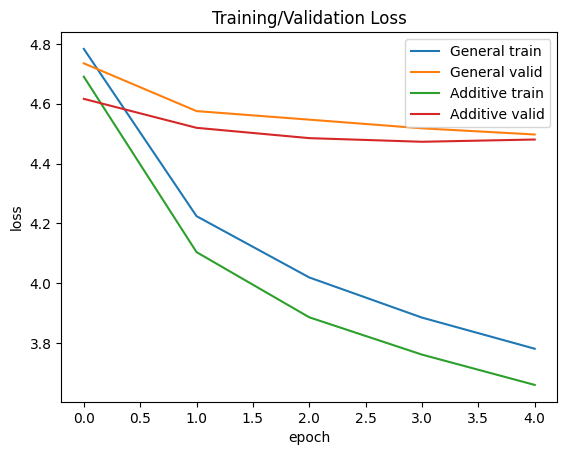

In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure()
plt.plot(gen_tr, label="General train")
plt.plot(gen_va, label="General valid")
plt.plot(add_tr, label="Additive train")
plt.plot(add_va, label="Additive valid")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training/Validation Loss")
plt.legend()
plt.show()

In [59]:
results = pd.DataFrame([
    {"Attention":"General",  "Train Loss": gen_tr[-1], "Train PPL": math.exp(gen_tr[-1]), "Val Loss": gen_va[-1], "Val PPL": math.exp(gen_va[-1])},
    {"Attention":"Additive", "Train Loss": add_tr[-1], "Train PPL": math.exp(add_tr[-1]), "Val Loss": add_va[-1], "Val PPL": math.exp(add_va[-1])}])
results

,Attention,Train Loss,Train PPL,Val Loss,Val PPL
0,General,3.780928,43.856718,4.497273,89.771992
1,Additive,3.659937,38.858891,4.480475,88.276573


In [60]:
def decode_indices(indices, itos):
    # stop at <eos>
    tokens = []
    for idx in indices:
        tok = itos[int(idx)]
        if tok == EOS:
            break
        if tok not in (SOS, PAD):
            tokens.append(tok)
    return tokens

@torch.no_grad()
def translate_with_attention(model, th_sentence, max_len=30):
    model.eval()
    src_tokens = [SOS] + tokenize_th(th_sentence) + [EOS]
    src_ids = torch.tensor([src_stoi.get(t, src_stoi[UNK]) for t in src_tokens], dtype=torch.long).unsqueeze(1).to(DEVICE)
    encoder_outputs, hidden = model.encoder(src_ids)

    input_tok = torch.tensor([tgt_stoi[SOS]], dtype=torch.long).to(DEVICE)  # [1]
    attn_matrix = []
    out_tokens = []

    for _ in range(max_len):
        pred, hidden, attn = model.decoder(input_tok, hidden, encoder_outputs)
        top1 = pred.argmax(1)  # [1]
        tok = tgt_itos[int(top1)]
        attn_matrix.append(attn.squeeze(1).detach().cpu())  # [src_len]
        if tok == EOS:
            break
        out_tokens.append(tok)
        input_tok = top1

    attn_mat = torch.stack(attn_matrix, dim=0) if attn_matrix else torch.zeros(1, len(src_tokens))
    return src_tokens, out_tokens, attn_mat

example_th = "ฉันรักประเทศไทย"
src_toks, out_toks, attn_mat = translate_with_attention(model_additive, example_th)
print("SRC:", src_toks)
print("OUT:", out_toks[:20])
print("Attention matrix shape:", attn_mat.shape)

SRC: ['<sos>', 'ฉัน', 'รัก', 'ประเทศ', 'ไทย', '<eos>']
OUT: ['i', 'love', 'love', 'love']
Attention matrix shape: torch.Size([5, 6])


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 3593 (\N{THAI CHARACTER CHO CHING}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 3633 (\N{THAI CHARACTER MAI HAN-AKAT}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 3585 (\N{THAI CHARACTER KO KAI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 3611 (\N{THAI CHARACTER PO PLA}) missing from font(s) DejaVu Sans.
  fig.canv

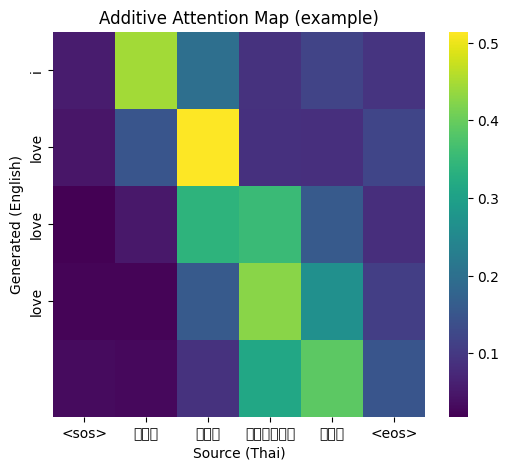

In [61]:
# Plot attention heatmap
plt.figure(figsize=(min(12, 0.5*len(src_toks)+3), min(8, 0.5*len(out_toks)+3)))
sns.heatmap(attn_mat.numpy(), xticklabels=src_toks, yticklabels=out_toks, cmap="viridis")
plt.xlabel("Source (Thai)")
plt.ylabel("Generated (English)")
plt.title("Additive Attention Map (example)")
plt.show()


- **Save models:**
Saves model weights + vocab to a single file.

In [62]:
ckpt_path = os.path.join(BASE_DIR, "mt_attention_ckpt.pt")
torch.save({
    "general_state_dict": model_general.state_dict(),
    "additive_state_dict": model_additive.state_dict(),
    "src_stoi": src_stoi, "src_itos": src_itos,
    "tgt_stoi": tgt_stoi, "tgt_itos": tgt_itos,
    "config": {
        "MAX_SAMPLES": MAX_SAMPLES, "VOCAB_SIZE": VOCAB_SIZE, "BATCH_SIZE": BATCH_SIZE,
        "EMB_DIM": EMB_DIM, "HID_DIM": HID_DIM, "DROPOUT": DROPOUT }}, ckpt_path)
print("Saved checkpoint to:", ckpt_path)

Saved checkpoint to: /content/drive/MyDrive/Colab Notebooks/data/mt_attention_ckpt.pt


## **Summary**

We use the **OpenSubtitles English–Thai parallel corpus** for machine translation.  
The dataset is preprocessed by normalizing text, removing empty sentence pairs, and splitting into train/validation/test sets.  
Thai text is tokenized using **PyThaiNLP**, while English text is tokenized by lowercasing and whitespace splitting.

A sequence-to-sequence model with a **Bi-GRU encoder** and **GRU decoder** is implemented.  
Two attention mechanisms are compared: **General Attention** and **Additive (Bahdanau) Attention**.

Experimental results show that **Additive Attention** achieves slightly better validation perplexity than General Attention.  
Attention heatmaps are visualized to demonstrate how the model aligns source and target tokens.  
Due to limited training epochs and reduced dataset size for computational efficiency, the attention alignment is not perfectly diagonal, which is expected.